In [ ]:
!pip -q install geopandas
!pip -q install keras-rl2

     |████████████████████████████████| 972kB 3.4MB/s 
     |████████████████████████████████| 14.8MB 304kB/s 
     |████████████████████████████████| 10.9MB 50.1MB/s 
     |████████████████████████████████| 61kB 2.2MB/s 


In [ ]:
import gym
import math
from gym import spaces
import numpy as np
import geopandas as gpd
from shapely.geometry import MultiPoint,Point
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt

class sea(gym.Env): 
       """
    Description:
        
        
    Observation:
        Type: Box(2)
        Num     Observation               Min                     Max
        0       Vessel's Longitude        -18e6                   18e6
        1       Vessel's Latitude         -9e6                    9e6
        
        In meters (Robinson projection)
    Actions:
        Type: Discrete(8)
        Num   Action
        0     Move to the North
        1     Move to North East
        2     Move to the East
        3     Move to South East
        4     Move to the South
        5     Move to South West
        6     Move to the West
        7     Move to North West
               
    Reward:
        Reward is -1/srt(2e5^2 + 2e5^2) for every step taken in cardinal direction.
        Reward is -1 for every diagonal move.
        Reward (-c,1): (total_distance - current_position)/total_distance
        Reward is [0,-0.5] for every change of direction. 
        Reward is 100 for the termination step.
        
    Starting State:
        Assigned from the user a starting and ending point. 
    Episode Termination:
        Vessel reaches the ending point.
    """     
    metadata = {'render.modes': ['human']}    
    def __init__(self,start_longitude,start_latitude,end_longitude,end_latitude):
        self.start_longitude = start_longitude
        self.start_latitude = start_latitude
        self.end_latitude = end_latitude
        self.end_longitude = end_longitude
#       distance between starting and ending port
        self.total_distance = math.sqrt((end_longitude-start_longitude)**2 + (start_latitude-start_latitude)**2)
        self.state = None
        self.previous_action = None
        self.action_space = spaces.Discrete(8)
        self.map_ = create_map()
        obs_max = [18e6,9e6]
        obs_min = [-18e6,-9e6]
        self.observation_space = spaces.Box(np.array(obs_min),np.array(obs_max),dtype=np.float64)
        self.history = {"action": [],"reward": []}
        try:
            with open('/content/drive/My Drive/edges.npy','rb') as fin:
                edges = np.load(fin,allow_pickle=True).tolist()
#             self.left_edges = edges['left_edges']
            self.right_edges = edges['right_edges']
        except:
            warnings.warn("Map Edges are not used")
#             self.left_edges = None
            self.right_edges = None

#   Compute the distance between starting and ending point
    def compute_distance(self,position):
        return math.sqrt((self.end_longitude-position[0])**2 + (self.end_latitude-position[1])**2) 

    def reset(self):
        self.state = self.start_longitude,self.start_latitude
        self.previous_action = None
        return  np.array(self.state) 
    
#   check whether a ship position is in the sea or land 
    def isvalid(self, position):
        return len(self.map_[self.map_.geometry.geom_almost_equals(Point(position[0],position[1]))]) != 0
    
    def step(self, action):
        if self.state == None:
            raise ValueError('Cannot call env.step() without calling reset()')
        if np.all(abs(np.array(self.state)) == self.right_edges,axis=1).sum() == 1:
            self.state = -self.state[0],self.state[1]
        if action == 0:  # move to the North
            move = self.state[0],self.state[1]+2e5
        elif action == 1:  # move to the North East
            move = self.state[0]+2e5,self.state[1]+2e5
        elif action == 2: # move to the East
            move = self.state[0]+2e5,self.state[1]
        elif action == 3: # move to the South East
            move = self.state[0]+2e5,self.state[1]-2e5
        elif action == 4: # move to the South
            move = self.state[0],self.state[1]-2e5
        elif action == 5: # move to the South West
            move = self.state[0]-2e5,self.state[1]-2e5
        elif action == 6:  # move to the West
            move = self.state[0]-2e5,self.state[1]
        elif action == 7: # move to the North West
            move = self.state[0]-2e5,self.state[1]+2e5
        else:
            raise ValueError('Actions are between 0 and 7')
        if self.isvalid(move):
            self.state = move
            done = bool(self.state == (self.end_longitude,self.end_latitude))
            a = 0.6
            if not done:
                if action%2 == 0:
                    reward = (- (1-a)*(2e5/math.sqrt(2e5**2+2e5**2)) + a*((self.total_distance - self.compute_distance(move))/self.total_distance))
                else:
                    reward = (-(1-a)*1 + a*((self.total_distance - self.compute_distance(move))/self.total_distance))
                if self.did_turn(action):
                    reward += -self.angle_turn(action)
            else:
                reward = 100
        else:
            done = True
            reward = -10

        self.history['action'].append(action)
        self.history['reward'].append(reward)    
        self.previous_action = action 
        return np.array(self.state), reward, done, {}

#   Check whether the vessel did turn     
    def did_turn(self,action):
        if self.previous_action == None:
            return False
        elif self.previous_action == action :
            return False
        else:
            return True   

#   Mesure the turning angle
    def angle_turn(self,action):
        r = abs((action/8 - self.previous_action/8))
        return r if r < 0.5 else 1-r
    
    
    def render(self,mode='human'):
        fig, ax = plt.subplots(figsize=(20, 20))
        self.map_.plot(ax=ax)
        point = Point(self.state[0],self.state[1])
        start = Point(self.start_longitude,self.start_latitude)
        end = Point(self.end_longitude,self.end_latitude)

        ax.scatter(point.x,point.y,color='red',marker='*',s=150,label='Ship\'s location')
        ax.scatter(start.x,start.y,color='black',s=150,label='Starting Port')
        ax.scatter(end.x,end.y,color='orange',s=150,label='Ending Port')
        

        ax.set_title("Ocean grid: Robinson Coordinate Reference System,",fontsize = 20)
        ax.set_xlabel("X Coordinates (meters)",fontsize = 20)
        ax.set_ylabel("Y Coordinates (meters)",fontsize = 20)
        ax.legend()

        for axis in [ax.xaxis, ax.yaxis]:
            formatter = ScalarFormatter()
            formatter.set_scientific(False)
            axis.set_major_formatter(formatter)
        plt.show()

        
def create_map(n=5e-6):
    ocean = gpd.read_file('/content/drive/My Drive/b/ne_10m_ocean_scale_rank.shp')
    ocean = ocean.to_crs('ESRI:54030')
    result=[]
    for i in range(len(ocean)):
        xmin, ymin, xmax, ymax = ocean.bounds.loc[i].T.values
        x = np.arange(np.floor(xmin * n) / n, np.ceil(xmax * n) / n, 1 / n)
        y = np.arange(np.floor(ymin * n) / n, np.ceil(ymax * n) / n, 1 / n)    

        grid = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
        points = MultiPoint(grid)

        if ocean.geometry[i].is_valid:
            result.append(points.intersection(ocean.geometry.loc[i]))
        else:
            result.append(points.intersection(ocean.geometry.loc[i].buffer(0)))
        results = [j for i in result for j in i]
    return gpd.GeoDataFrame(results,columns=['geometry'],crs=ocean.crs)

In [ ]:
def edges(env,up = True,right = True):
    env.reset()
    loc = 0
    end = False
    points = []
# For upward or downward movements
    if up:
        a = 0
    else:
        a = 4
# Finding right or left edges
    if right:
        b = 2
    else:
        b = 6
        
    while True:
        while not end: 
            loc,_,end,_ =  env.step(b)
        _,_,end,_ =  env.step(a)         
        if loc[1] == -200000. or loc[1] == -400000:
            end = True
        points.append(loc)
        if end:
            break
    return points 
def find_edges:
    env = sea(9000000., 8600000.,-5000000.000+2e5, 6e5)
    points1 = edges(env,up = False)
    env = sea(13200000.,  6600000.,-5000000.000+2e5, 6e5)
    points2 = edges(env,up = False)
    env = sea(15600000.0,-4200000.0,-5000000.000+2e5, 6e5)
    points3 = edges(env)
    env = sea(10200000., -8200000.,-5000000.000+2e5, 6e5)
    points4 = edges(env)
    right_edges = points1+points2+points3+points4

    env = sea(-9000000., 8600000.,-5000000.000+2e5, 6e5)
    left1 = edges(env,up=False,right=False)
    env = sea(-12800000.0,6800000.0,-5000000.000+2e5, 6e5)
    left2 = edges(env,up=False,right=False)
    env = sea(-10200000., -8200000.,-5000000.000+2e5, 6e5)
    left3 = edges(env,up=True,right=False)
    left_edges = left1+left2+left3
    with open('edges.npy', 'wb') as fout:
        np.save(fout,{"left_edges":left_edges,"right_edges":right_edges})

In [ ]:
import numpy as np
from math import exp
import gym
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Input,Dropout,Reshape,BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.models import Model 
from tensorflow.keras.losses import Huber

from rl.processors import WhiteningNormalizerProcessor
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import TrainEpisodeLogger,FileLogger


class seaProcessor(WhiteningNormalizerProcessor):
    def process_reward(self, reward):
        return np.clip(reward, -100., np.inf)

# Get the environment and extract the number of actions.
# env = sea(-600000.000-2e5, 6000000.000,-5000000.000+2e5, 6e5)
env = sea(5000000,-3200000,-5000000.000+2e5, 6e5)
# env.reset()
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n


input = Input(shape=(2,)+ env.observation_space.shape, name='Input')
x = input
# x = Reshape((2,))(x)
x = Flatten()(x)
# x = BatchNormalization()(x)
x = Dense(units= 2*16,kernel_initializer='glorot_uniform', activation='relu')(x)
x = Dense(units= 2*16,kernel_initializer='glorot_uniform', activation='relu')(x)
x = Dropout(0.1)(x)
# x = Dense(units= 2*16,kernel_initializer='glorot_uniform', activation='relu')(x)

output = Dense(units=nb_actions, kernel_initializer='glorot_uniform', activation='linear', name='Output')(x)
model = Model(inputs=input, outputs=output)
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=170000, window_length=2)
# policy = BoltzmannQPolicy()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=170000)
# policy = LinearAnnealedPolicy(BoltzmannQPolicy(), attr='tau', value_max=1.05, value_min=.98, value_test=1., nb_steps=50000)
dqn = DQNAgent(model=model, nb_actions=nb_actions,gamma=0.99, memory=memory,enable_double_dqn=True,nb_steps_warmup=150,
               target_model_update=5e-4, policy=policy,train_interval=2,processor=seaProcessor())#5e-4
dqn.compile(Adam(lr=1e-3),  metrics=[Huber()])#1e-3
 
log_filename = 'dqn_capstone_log.json'
# callbacks = [TrainEpisodeLogger()]
callbacks = [FileLogger(log_filename, interval=100)]

history = dqn.fit(env, nb_steps=170000,callbacks=callbacks,action_repetition=1, visualize=False, verbose=1)

# After training is done, we save the final weights.
# dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
# dqn.test(env, nb_episodes=1, visualize=False, verbose=1)

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2, 2)]            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 8)                 264       
Total params: 1,480
Trainable params: 1,480
Non-trainable params: 0
___________________________________________________

In [ ]:
# env2 = sea(-600000.000-2e5, 6000000.000,-5000000.000+10e5, 6e5+5e5)
test_history = dqn.test(env, nb_episodes=2,nb_max_episode_steps=200, visualize=False, verbose=2)

Testing for 2 episodes ...
Episode 1: reward: -14.104, steps: 65
Episode 2: reward: -14.104, steps: 65


In [ ]:
env.render()

In [ ]:
# test_history.history
pd.DataFrame(history.history).plot("nb_steps","episode_reward",marker='o')
d = pd.DataFrame(history.history)
d[d.episode_reward>0]

In [ ]:
data = pd.DataFrame(env.history)
data[data.reward==100]
data[len(data)-29:]

In [ ]:
import json

def visualize_log(filename, figsize=None, output=None):
    with open(filename, 'r') as f:
        data = json.load(f)
    if 'episode' not in data:
        raise ValueError('Log file "{}" does not contain the "episode" key.'.format(filename))
    episodes = data['episode']

    # Get value keys. The x axis is shared and is the number of episodes.
    keys = sorted(list(set(data.keys()).difference(set(['episode']))))

    if figsize is None:
        figsize = (15., 5. * len(keys))
    f, axarr = plt.subplots(len(keys), sharex=True, figsize=figsize)
    for idx, key in enumerate(keys):
        axarr[idx].plot(episodes, data[key])
        axarr[idx].set_ylabel(key)
    plt.xlabel('episodes')
    plt.tight_layout()
    if output is None:
        plt.show()
    else:
        plt.savefig(output)


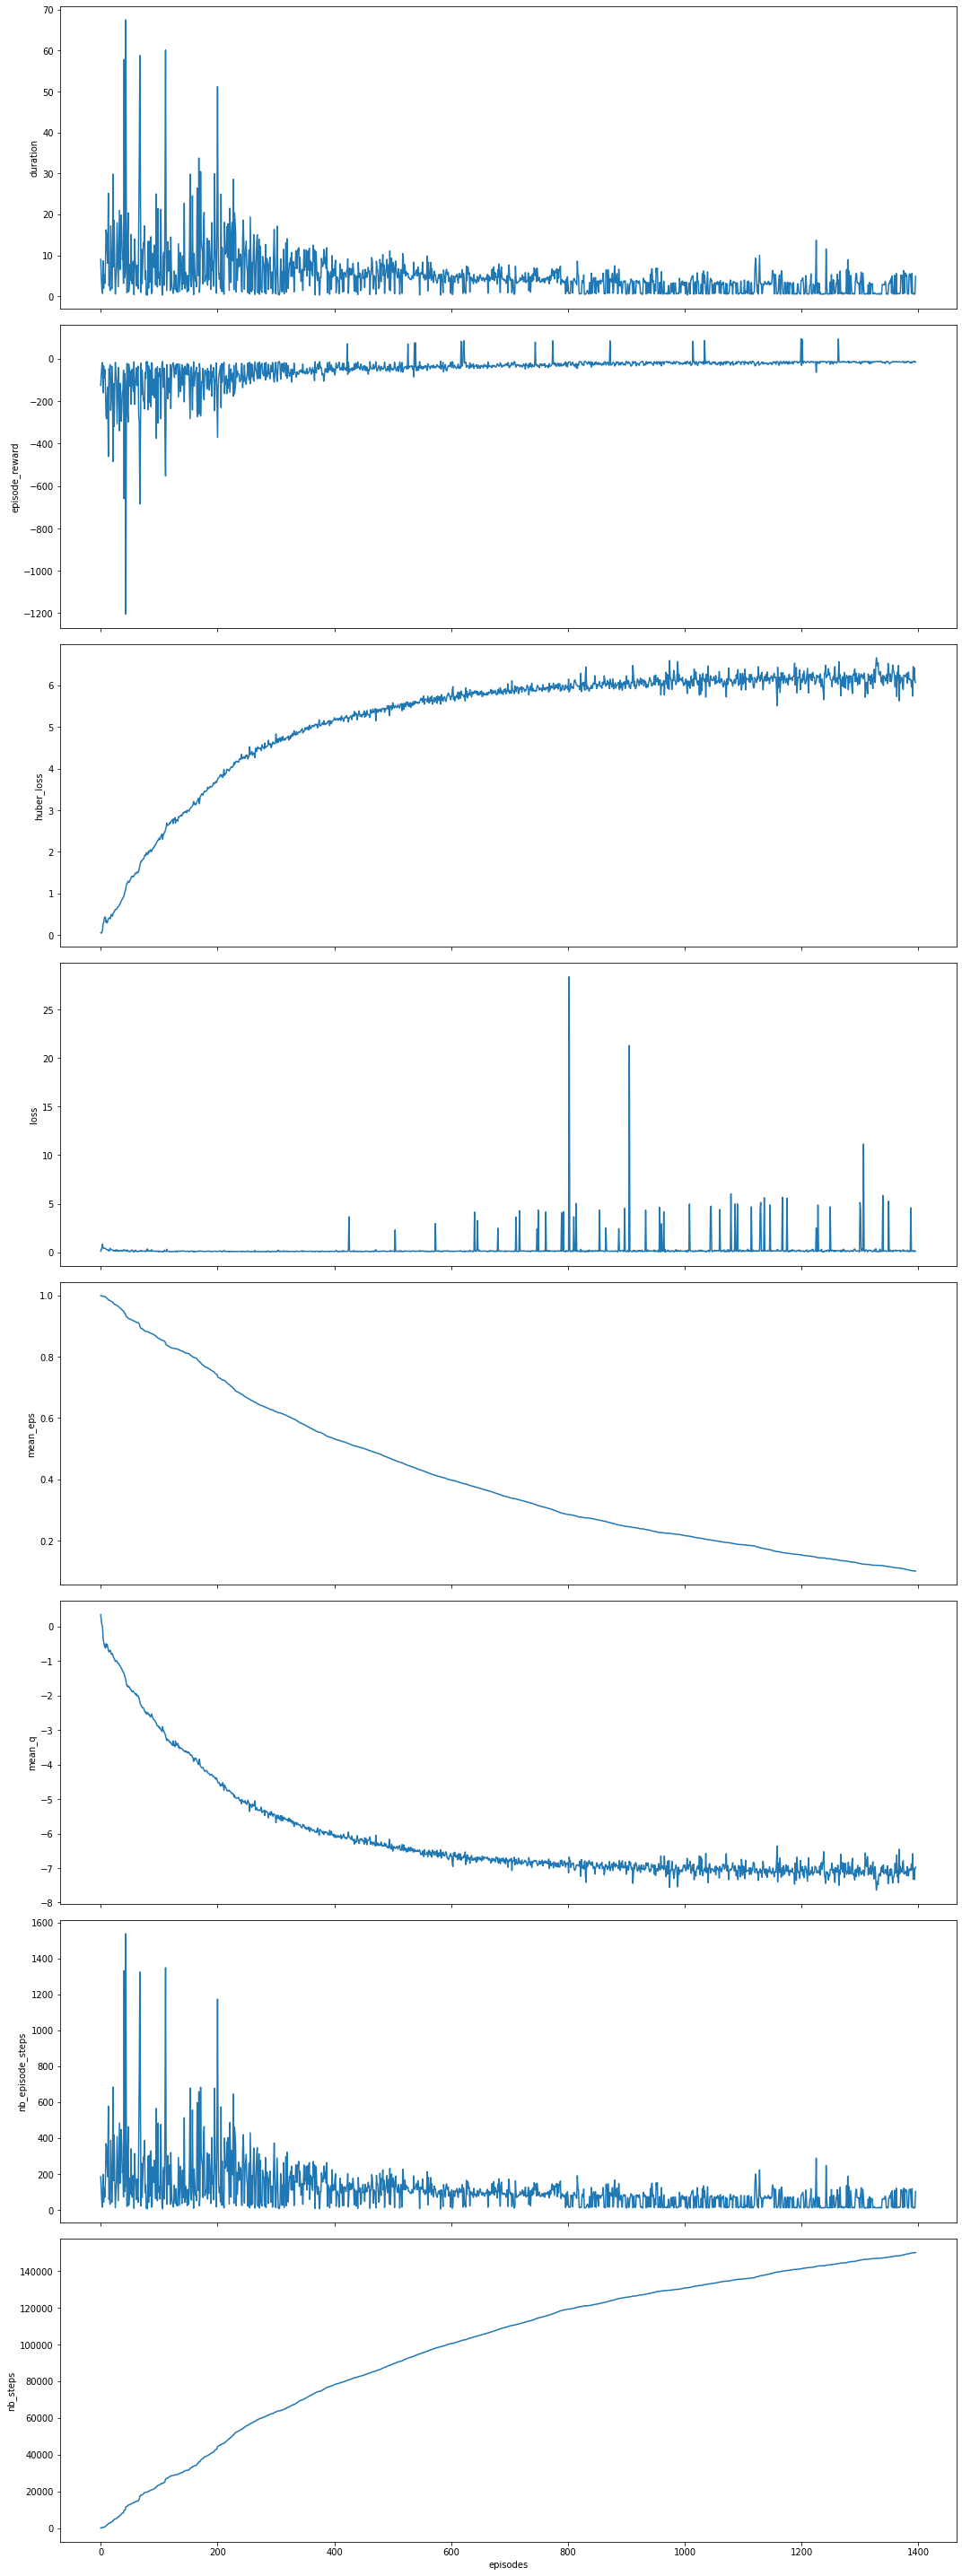

In [ ]:
path = '/content/dqn_capstone_log.json'
visualize_log(path)

,loss,huber_loss,mean_q,mean_eps,episode_reward,nb_episode_steps,nb_steps,episode,duration
2180,11.109780,7.123697,3.817240,0.107405,90.868626,32,109112,2180,1.377243
2181,31.329367,7.207136,4.134410,0.107126,-18.936832,36,109148,2181,1.528049
2182,28.819822,7.498793,4.745248,0.106840,-18.205357,33,109181,2182,1.403106
2183,NaN,NaN,NaN,NaN,-10.000000,1,109182,2183,0.047611
2184,25.909999,7.274534,3.897822,0.106578,-17.545519,30,109212,2184,1.288132
2185,32.429541,6.469114,2.777017,0.106333,89.673008,30,109242,2185,1.278008
2186,18.746820,6.850658,3.185543,0.106079,89.865935,32,109274,2186,1.395372
2187,11.788697,6.445492,2.703219,0.105817,90.767261,31,109305,2187,1.308852
2188,20.856711,7.267524,4.012252,0.105555,91.255592,32,109337,2188,1.379203
2189,26.438590,7.345909,4.751187,0.105285,90.578474,35,109372,2189,1.522845


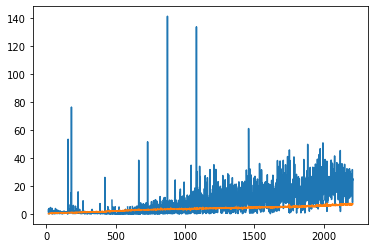

In [ ]:
logs = pd.read_json('/content/dqn_capstone_log.json')
# pd.DataFrame(np.array(logs.episode_reward.cumsum()),columns=['cumulative_reward']).plot(figsize=(15.,10.),fontsize=18)
# plt.legend(loc='upper left',fontsize=18)
# plt.xlabel('Number of Episodes ',fontsize=18)
# plt.title(label='Cumulative reward over episodes', fontsize=18)
# plt.show()
logs.loss[15:].plot()
logs.huber_loss[15:].plot()
# logs[3570:]
# logs.episode_reward.cumsum().plot()
# logs[len(logs)-50:]
logs[len(logs)-30:]

In [ ]:
ENV_NAME = 'capstone'
dqn.save_weights('/content/drive/My Drive/Colab Notebooks/dqn_double_agent_{}_weights.h5f'.format(ENV_NAME), overwrite=True)
